In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm as tqdm
from astropy.constants import c
import pandas as pd
from getdist import plots, MCSamples,mcsamples

In [2]:
def logMetropolisHastings(logTargetProbability,size = 10000):
    #Q = lambda x,y : np.exp(-(x-y)**2/2)/(2*np.pi) it's simmetric it's useless
    initialPoint = np.array([0.7,0.3])
    cov = np.diag(initialPoint*0.001)
    chain = initialPoint
    currentPosition = initialPoint
    currentProb = logTargetProbability(currentPosition)
    for i in tqdm(range(size)):
        newPosition = np.random.multivariate_normal(currentPosition,cov)
        newProb = logTargetProbability(newPosition)
        a = newProb - currentProb
        if np.random.uniform(0,1) <= np.exp(a):
            currentPosition = newPosition
            currentProb = newProb
        chain = np.vstack((chain,currentPosition))
    return chain

In [3]:
def integrate1D(function,extremes,size = 100):
    #metodo di calcolo di integrali senza singolarità negli estremi,
    #metodo dei trapezioidi iterati
    a,b = extremes
    result = (function(a)+function(b))*0.5
    for i in range(size):
        point = a + i*(b-a)/size
        result += function(point)
    return result*(b-a)/size

def simpson(function,extremes,steps):
    a,b = extremes
    h = (b-a)/steps
    summ = function(a) + function(b)
    for i in range(steps):
        if i % 2 == 0:
            summ += 2*function(a+h*i)
        else:
            summ += 4*function(a+h*i)
    return summ*h/3

def integralSimpson(function,extremes, err = 0.01):
    a,b = extremes
    steps = 16
    needSteps = ((b-a)/np.sqrt((err*3*(b-a)**2)/(4*steps**2*np.abs(simpson(function,extremes,steps)-simpson(function,extremes,int(steps*0.5))))).astype(int))
    return simpson(function,extremes,needSteps)

In [4]:
tbl = pd.read_csv('Pantheon+SH0ES.dat',delim_whitespace = 1)
data = np.array(tbl['zHD'])
data_err = np.array(tbl['zHDERR'])
exp = np.array(tbl['MU_SH0ES'])
mu_err = np.array(tbl['MU_SH0ES_ERR_DIAG'])
#mtrxTbl = np.loadtxt("Pantheon+SH0ES_STAT+SYS.cov")
#covMat = np.reshape(mtrxTbl,(1701,1701))
#invCov = np.linalg.inv(covMat)

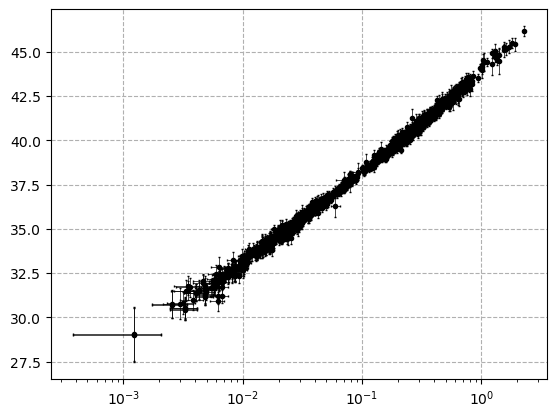

In [5]:
plt.errorbar(x = data,xerr=data_err,y = exp,yerr = mu_err,fmt=".", color="black",elinewidth=.5,capsize=1)
plt.grid(linestyle='--')
plt.xscale('log')

In [6]:
origlen = len(tbl['zHD'])
print(origlen)
cosmo = (tbl['zHD']>0.01) | (np.array(tbl['IS_CALIBRATOR'],dtype=bool))
z = np.array(tbl['zHD'][cosmo])
data_err = np.array(tbl['zHDERR'][cosmo])
exp = np.array(tbl['MU_SH0ES'][cosmo])
mu_err = np.array(tbl['MU_SH0ES_ERR_DIAG'][cosmo])
print(len(z))

1701
1657


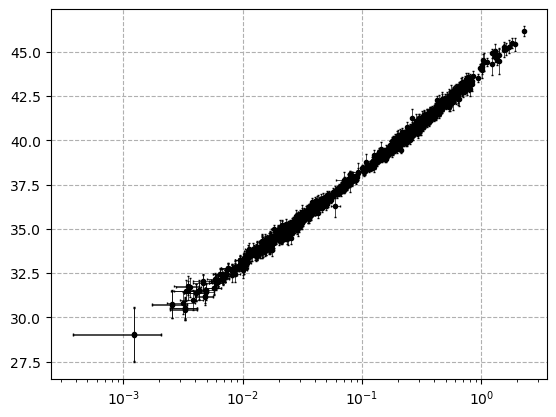

In [7]:
plt.errorbar(x = z,xerr=data_err,y = exp,yerr = mu_err,fmt=".", color="black",elinewidth=.5,capsize=1)
plt.grid(linestyle='--')
plt.xscale('log')

In [8]:
filename = "Pantheon+SH0ES_STAT+SYS.cov"
f = open(filename)
line = f.readline()
n = int(len(z))
C = np.zeros((n,n))
ii = -1
jj = -1
for i in range(origlen):
    jj = -1
    if cosmo[i]:
        ii += 1
    for j in range(origlen):
        if cosmo[j]:
            jj += 1
        val = float(f.readline())
        if cosmo[i]:
            if cosmo[j]:
                C[ii,jj] = val
f.close()
invCov = np.linalg.inv(C)

In [9]:
def teoModel(theta):
    h,omega_m = theta
    integrando = lambda z: 1/(np.sqrt(omega_m*(1+z)**3+1-omega_m))
    zeff = z[~np.array(tbl['IS_CALIBRATOR'][cosmo],dtype=bool)]
    extremesInt = [0,zeff]
    d_l_tilde = (1+zeff)*c.to("km/s").value/100*simpson(integrando,extremesInt,50)
    #a = 1/(1+z)
    #d_l_tilde = (1+z)*c.to("km/s").value/100*(eta(1,omega_m)-eta(a,omega_m))
    return (25 - 5*np.log10(h) + 5 * np.log10(d_l_tilde))

def eta(a,omega_m):
    s = ((1- omega_m)/omega_m)**(1/3)
    return 2*(s**3+1)**(1/2)*(1/a**4-0.1540*s/a**3+0.4304*s**2/a**2+0.19097*s**3/a+0.066941*s**4)**(-1/8)

In [10]:
def chi2(theta):
    vector = z*np.nan
    vector[np.array(tbl['IS_CALIBRATOR'][cosmo],dtype=bool)] = (tbl['MU_SH0ES'][np.array(tbl['IS_CALIBRATOR'],dtype=bool)][cosmo] 
        - tbl['CEPH_DIST'][np.array(tbl['IS_CALIBRATOR'],dtype=bool)][cosmo])
    vector[~np.array(tbl['IS_CALIBRATOR'][cosmo],dtype=bool)] = (tbl['MU_SH0ES'][~np.array(tbl['IS_CALIBRATOR'],dtype=bool)][cosmo] -
                                                                 teoModel(theta))
    transposed = np.transpose(vector)
    temp = np.matmul(invCov,vector)
    return np.matmul(transposed, temp)

In [11]:
def logPosterior(theta):
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + logLike(theta)

In [12]:
def logLike(theta):
    return -chi2(theta)/2

In [13]:
def logPrior(theta):
    h,omega_m = theta
    if  (0 < omega_m < 1) & (0 < h < 1) : 
        return 0.0
    else:
        return -np.inf

In [14]:
catena = logMetropolisHastings(logPosterior,size = 30000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [02:44<00:00, 182.88it/s]


In [15]:
names = labels = ['h','\Omega_m']
samples = MCSamples(samples=catena,names = names,labels = labels)
#samples.saveAsText('newSample60/samples60')

Removed no burn in


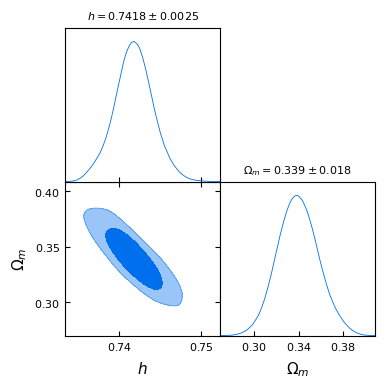

In [16]:
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True,title_limit=1)
 # first title limit (for 1D plots) is 68% by default

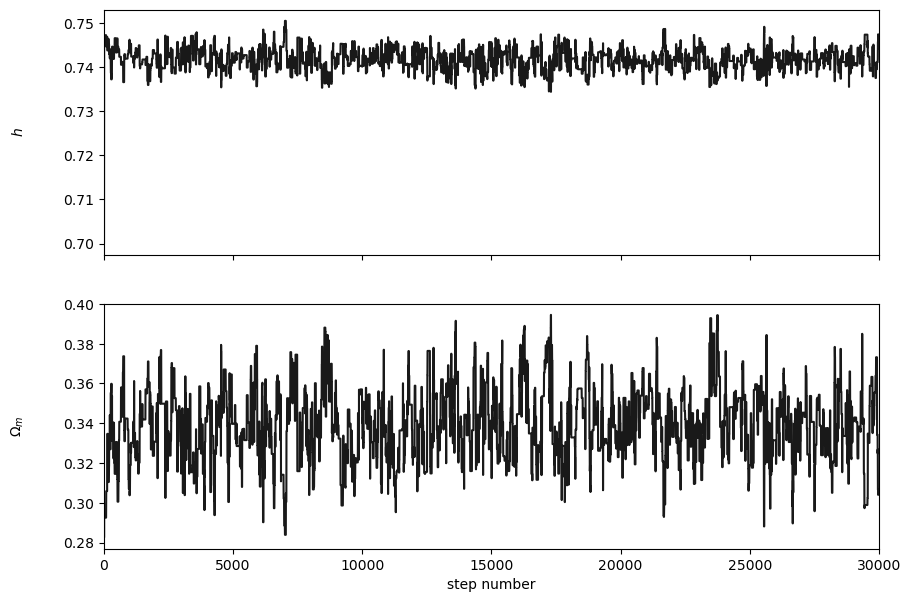

In [17]:
labelsPar = ["$h$", "$\Omega_m$"]
parNum = len(labelsPar)
fig, axes = plt.subplots(parNum, figsize=(10, 7), sharex=True)
for i in range(parNum):
    ax = axes[i]
    ax.plot(samples[i], "k", alpha=0.9)
    ax.set_xlim(0, len(samples[i]))
    ax.set_ylabel(labelsPar[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

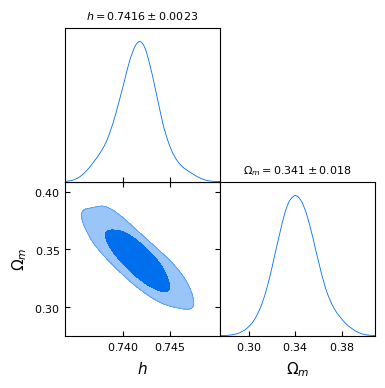

In [18]:
samples.removeBurn(10000)
samples.removeBurn(0.3)
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True,title_limit=1,)

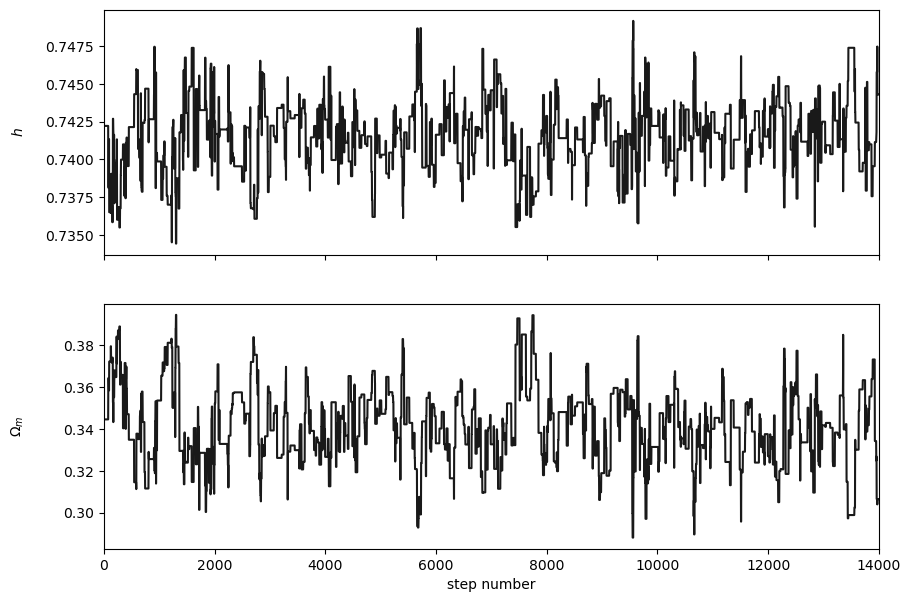

In [19]:
labelsPar = ["$h$", "$\Omega_m$"]
parNum = len(labelsPar)
fig, axes = plt.subplots(parNum, figsize=(10, 7), sharex=True)
for i in range(parNum):
    ax = axes[i]
    ax.plot(samples[i], "k", alpha=0.9)
    ax.set_xlim(0, len(samples[i]))
    ax.set_ylabel(labelsPar[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");